In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Евклидовая норма вектора
def norm(x):
    return sum(i**2 for i in x)**0.5

# Скалярное произведение векторов
def dot_product(a, b):
    return sum(x * y for x, y in zip(a, b))

# Произведение двух векторов
def outer_product(a, b):
    result = [[0] * len(b) for _ in range(len(a))]
    for i in range(len(a)):
        for j in range(len(b)):
            result[i][j] = a[i] * b[j]
    return np.array(result)

# Перемножение двух матриц
def matrix_dot(A, B):
    result = [[0] * len(B[0]) for _ in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return np.array(result)

# Транспонирование матрицы
def transpose_matrix(A):
    result = [[0] * len(A) for _ in range(len(A[0]))]
    for i in range(len(A)):
        for j in range(len(A[0])):
            result[j][i] = A[i][j]
    return np.array(result)

# правило Вулфа
def line_search(f, x, p, alpha0=1, c1=1e-4, c2=0.9, max_iter=100):
    alpha = alpha0
    for _ in range(max_iter):
        # Вычисление условий Вулфа
        left_side = f(x + alpha * p)
        right_side = f(x) + c1 * alpha * dot_product(gradient(f, x), p)

        left_curvature = dot_product(gradient(f, x + alpha * p), p)
        right_curvature = c2 * dot_product(gradient(f, x), p)

        # Проверка первого условия Вулфа (Армихо)
        if left_side > right_side:
            alpha *= 0.5  # Уменьшаем шаг, если не выполнено
        # Проверка второго условия Вулфа (кривизна)
        elif left_curvature < right_curvature:
            alpha *= 2.0  # Увеличиваем шаг, если локальная кривая слишком крутая
        else:
            break  # Оба условия выполнены
    return alpha


# Вычисление градиента
def gradient(f, x, epsilon=1e-8):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_h = x.copy()
        x_h[i] += epsilon
        grad[i] = (f(x_h) - f(x)) / epsilon
    return grad

# Барьерная функция для произвольного числа ограничений вида g(x) >= 0
def barrier(x, constraints):
    penalty = 0
    for constraint in constraints:
        value = constraint(x)
        # Если ограничение нарушено, то возвращаем бесконечность
        if value <= 0:
            return float('inf')
        # Прибавляем к штрафу логарифм значения ограничения
        penalty -= np.log(value)
    return penalty

# Целевая функция с учетом штрафа
def combined_func(x, mu, constraints):
    return objective(x) + mu * barrier(x, constraints)

# Метод Давидона-Флетчера-Пауэлла (DFP) с барьерной функцией
def dfp_method(f, x0, mu, tol=1e-6, max_iter=1000):
    n = len(x0)  # Размерность пространства
    H_k = np.eye(n)  # Инициализация матрицы H как единичной
    x_k = x0  # Начальное приближение решения
    num_iter = 0

    for num_iter in range(max_iter):
        # Вычисление градиента целевой функции
        grad = gradient(lambda x: combined_func(x, mu, constraints), x_k)

        # Если градиент достаточно мал, то останавливаемся
        if norm(grad) < tol:
            break

        # Вычисляем направление поиска p_k
        p_k = -matrix_dot(H_k, grad.reshape(-1, 1)).flatten()
        # Определяем оптимальный шаг alpha с помощью линейного поиска
        alpha = line_search(lambda x: combined_func(x, mu, constraints), x_k, p_k)

        # Обновляем шаг
        x_k_next = x_k + alpha * p_k
        # Обновляем градиент
        grad_next = gradient(lambda x: combined_func(x, mu, constraints), x_k_next)

        # Обновление параметров для метода DFP по формулам
        r_k = x_k_next - x_k
        s_k = grad_next - grad

        # Обновление матрицы H_k по формулам метода DFP
        # Подготовка
        s_k_mat = s_k.reshape(-1, 1)

        if (dot_product(r_k, s_k) > 1e-20 and dot_product(matrix_dot(H_k, s_k_mat), s_k) > 1e-20):
          # Само обновление H_k с учетом изменения градиента
          H_k = H_k + outer_product(r_k, r_k) / dot_product(r_k, s_k) - matrix_dot(matrix_dot(H_k, s_k_mat), transpose_matrix(matrix_dot(H_k, s_k_mat))) / dot_product(matrix_dot(H_k, s_k_mat), s_k)
        else:
          break
        # Переход к следующей итерации
        x_k = x_k_next

    return x_k, num_iter


Оптимальное решение: [3.00025027 2.00049979]
Значение целевой функции в оптимуме: 3.1242401236877854e-07


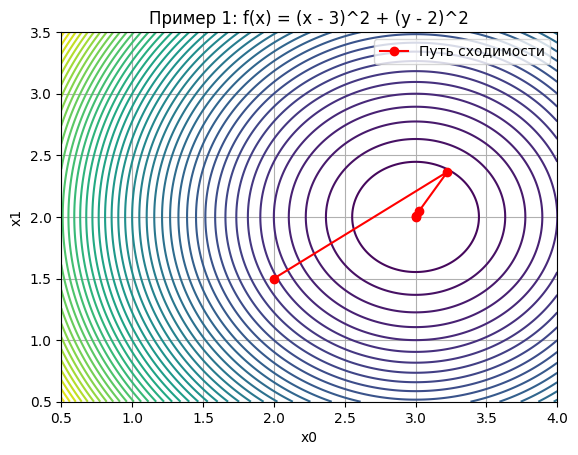

In [ ]:
# Целевая функция
def objective(x):
    return (x[0] - 3)**2 + (x[1] - 2)**2

def constraint1(x):
    return x[0] - 1

def constraint2(x):
    return x[1] - 1

# Начальные данные
x0 = np.array([2.0, 1.5])  # Начальная точка
mu_start = 1.0  # Начальное значение параметра штрафа
mu_end = 1e-3  # Конечное значение параметра штрафа для прекращения процесса
mu_reduction = 0.1  # Коэффициент уменьшения параметра штрафа на каждой итерации

constraints = [constraint1, constraint2]  # Список ограничений

# Начальные значения переменных для итерационного процесса
x_sol = x0
mu = mu_start
history = [x_sol.copy()]

# Цикл сходимости
while mu > mu_end:
    # Запускаем метод DFP для нахождения минимума с текущим значением mu
    x_sol, num = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction  # Уменьшаем mu, чтобы постепенно удалить влияние барьерной функции
    history.append(x_sol.copy())

print("Оптимальное решение:", x_sol)
print("Значение целевой функции в оптимуме:", objective(x_sol))

# Визуализация пути сходимости
x_vals = np.linspace(0.5, 4, 400)
y_vals = np.linspace(0.5, 3.5, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = (X - 3)**2 + (Y - 2)**2

plt.contour(X, Y, Z, levels=50)  # Контурный график уровней целевой функции
plt.plot([x[0] for x in history], [x[1] for x in history], 'ro-', label='Путь сходимости')
plt.xlim(0.5, 4)
plt.ylim(0.5, 3.5)
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.title('Пример 1: f(x) = (x - 3)^2 + (y - 2)^2')
plt.grid(True)
plt.show()

Оптимальное решение: [-0.00016666 -0.00016666]
Значение целевой функции в оптимуме: 8.332282913242884e-08


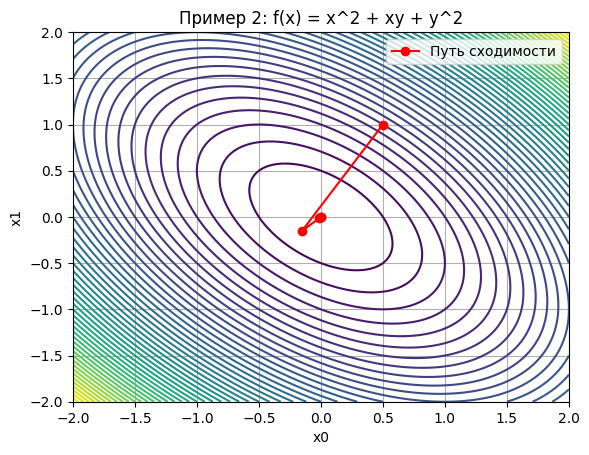

In [ ]:
# Целевая функция
def objective(x):
    return x[0]**2 + x[0]*x[1] + x[1]**2

def constraint1(x):
    return -x[0] + 2

def constraint2(x):
    return -x[1] + 2

x0 = np.array([0.5, 1.0])
mu_start = 1.0
mu_end = 1e-3
mu_reduction = 0.1

constraints = [constraint1, constraint2]

x_sol = x0
mu = mu_start
history = [x_sol.copy()]

while mu > mu_end:
    x_sol, num = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction
    history.append(x_sol.copy())

print("Оптимальное решение:", x_sol)
print("Значение целевой функции в оптимуме:", objective(x_sol))

x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X**2 + X * Y + Y**2

plt.contour(X, Y, Z, levels=50)
plt.plot([x[0] for x in history], [x[1] for x in history], 'ro-', label='Путь сходимости')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.title('Пример 2: f(x) = x^2 + xy + y^2')
plt.grid(True)
plt.show()

In [ ]:
def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 2000000 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

x0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
mu_start = 1.0
mu_end = 1e-3
mu_reduction = 0.1

constraints = [constraint1]

x_sol = x0
mu = mu_start
history = [x_sol.copy()]

while mu > mu_end:
    x_sol, num = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction
    history.append(x_sol.copy())

print("Оптимальное решение:", x_sol)
print("Значение целевой функции в оптимуме:", objective(x_sol))


Оптимальное решение: [ 1.3248356   1.70420186  2.85235111  8.10948573 65.76375843]
Значение целевой функции в оптимуме: 78.9387887058618


In [ ]:
def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

# Начальные данные
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # Начальная точка
mu_start = 1.0  # Начальное значение параметра штрафа
mu_end = 1e-3  # Конечное значение параметра штрафа для прекращения процесса
mu_reduction = 0.1  # Коэффициент уменьшения параметра штрафа на каждой итерации

constraints = [constraint1]  # Список ограничений

# Начальные значения переменных для итерационного процесса
x_sol = x0
mu = mu_start
history = [x_sol.copy()]

# Цикл сходимости
while mu > mu_end:
    # Запускаем метод DFP для нахождения минимума с текущим значением mu
    x_sol, num = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction
    history.append(x_sol.copy())

print("Оптимальное решение:", x_sol)
print("Значение целевой функции в оптимуме:", objective(x_sol))


<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


Оптимальное решение: [1.12351745 1.2015847  1.36421716 1.78741893 3.14578244]
Значение целевой функции в оптимуме: 127.83767291054248


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Определение целевой функции
def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])


### Оптимизация

# Начальное предположение
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# Выполнение оптимизации
result = minimize(objective, x0)

# Результаты
optimal_x = result.x
optimal_value = result.fun

print("Оптимальные значения переменных:", optimal_x)
print("Оптимальное значение функции:", optimal_value)


Оптимальные значения переменных: [ 1.32483905  1.7042027   2.85235099  8.10948754 65.76378813]
Оптимальное значение функции: 78.93878870180826


In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # Начальное приближение

constraints = [{
    'type': 'ineq',
    'fun': constraint1
}]

result = minimize(objective, x0, method='trust-constr', constraints=constraints, options={'verbose': 1})

print("Оптимальное решение:", result.x)
print("Значение целевой функции в оптимуме:", result.fun)

python_optimized = result.fun


`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 606, CG iterations: 277, optimality: 1.69e-06, constraint violation: 0.00e+00, execution time: 0.17 s.
Оптимальное решение: [1.12352117 1.20159318 1.36423799 1.7874769  3.14599159]
Значение целевой функции в оптимуме: 127.83667319931448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


<ipython-input-62-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-62-54cb676345f5>:26: RuntimeWarning: invalid value encountered in scalar multiply
  result[i][j] += A[i][k] * B[k][j]


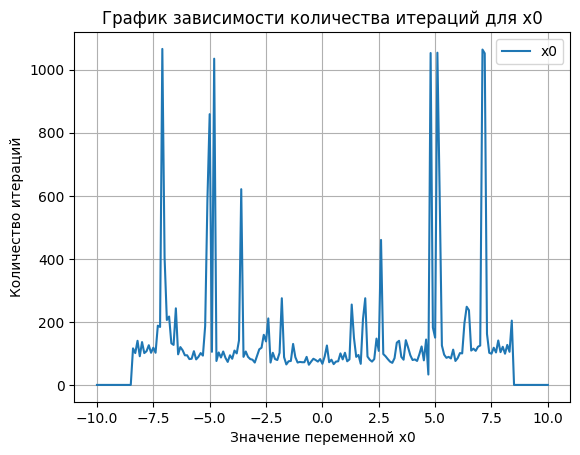

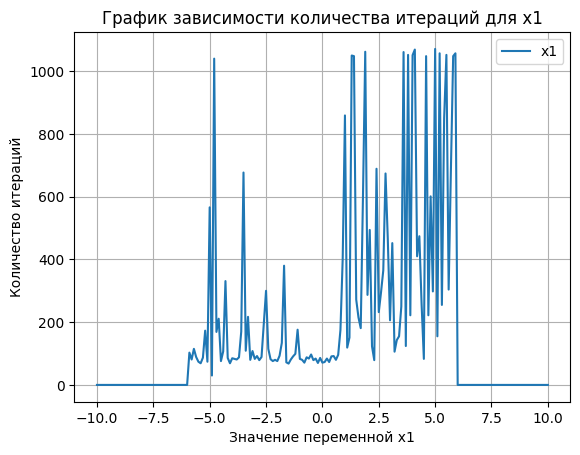

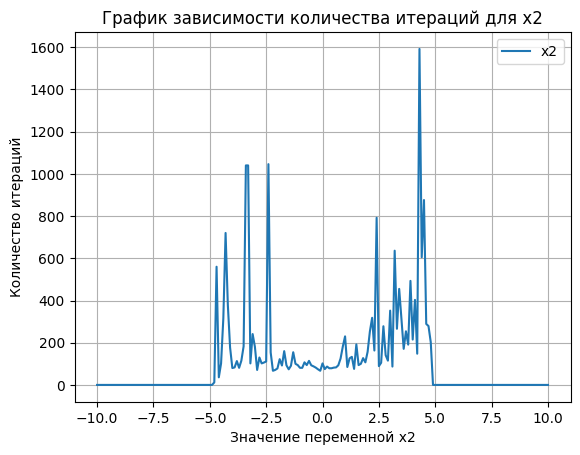

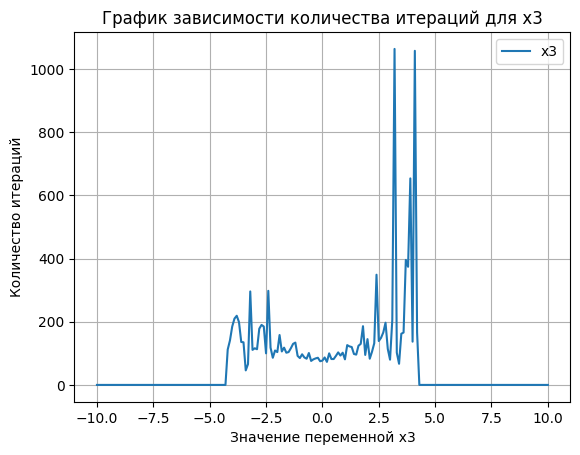

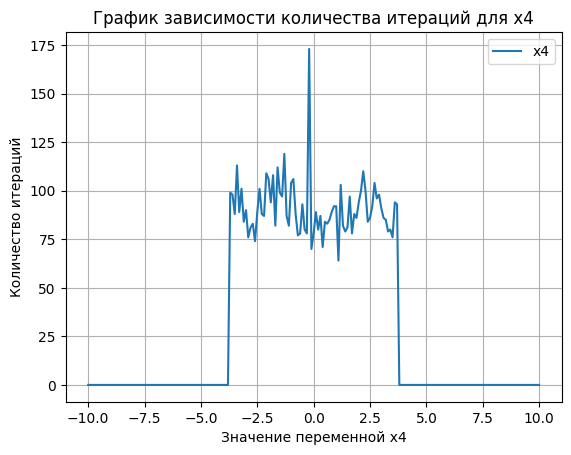

In [ ]:
'''
import numpy as np
import pandas as pd

def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

# Исследование зависимости числа итераций от изменения начальной точки
def explore_initial_points():
  results = []
  constraints = [constraint1]
  mu_start = 1.0
  mu_end = 1e-3
  mu_reduction = 0.1

  # Изменяем каждую компоненту x0 от -10 до 10
  for var_index in range(5):  # пробегаем по каждой переменной
    results = []

    for varying_value in np.arange(-10, 10.1, 0.1):
      x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)
      x0[var_index] = varying_value
      x_sol = x0
      mu = mu_start
      total_iterations = 0

      while mu > mu_end:
        x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
        mu *= mu_reduction
        total_iterations += num_iter

      f_val = objective(x_sol)
      x0_str = "[" + ", ".join(f"{v:.2f}" for v in x0) + "]"
      x_sol_str = "[" + ", ".join(f"{v:.2f}" for v in x_sol) + "]"
      results.append((x0_str, x_sol_str, f"{f_val:.2f}", total_iterations))

    df = pd.DataFrame(results, columns=['начальная точка x_0', 'найденное решение x_min', 'f(x_min)', 'Количество итераций'])

    pd.set_option('display.float_format', '{:.2f}'.format)
    print(df.to_string(index=False))
    print('\n\n')

  return df

results_df = explore_initial_points()
'''


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

# Исследование зависимости числа итераций от изменения начальной точки
def explore_initial_points():
    constraints = [constraint1]
    mu_start = 1.0
    mu_end = 1e-3
    mu_reduction = 0.1
    results = {'var_index': [], 'varying_value': [], 'iterations': []}

    # Изменяем каждую компоненту x0 от -10 до 10
    for var_index in range(5):  # пробегаем по каждой переменной
        for varying_value in np.arange(-10, 10.1, 0.1):
            x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)
            x0[var_index] = varying_value
            x_sol = x0
            mu = mu_start
            total_iterations = 0

            while mu > mu_end:
                x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
                mu *= mu_reduction
                total_iterations += num_iter

            results['var_index'].append(var_index)
            results['varying_value'].append(varying_value)
            results['iterations'].append(total_iterations)

    return results

results = explore_initial_points()

for var_index in range(5):
    # Получаем данные для текущей переменной
    x_vals = [results['varying_value'][i] for i in range(len(results['var_index'])) if results['var_index'][i] == var_index]
    y_vals = [results['iterations'][i] for i in range(len(results['var_index'])) if results['var_index'][i] == var_index]

    # Создаем график
    plt.figure()
    plt.plot(x_vals, y_vals, label=f'x{var_index}')
    plt.xlabel(f'Значение переменной x{var_index}')
    plt.ylabel('Количество итераций')
    plt.title(f'График зависимости количества итераций для x{var_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

results = []
constraints = [constraint1]
mu_start = 1.0
mu_end = 1e-3
mu_reduction = 0.1

results = []

for varying_value in np.arange(-50, 51, 1):
  x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)

  for var_index in range(len(x0)):
    x0[var_index] = varying_value

  x_sol = x0
  mu = mu_start
  total_iterations = 0

  while mu > mu_end:
    x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction
    total_iterations += num_iter

  f_val = objective(x_sol)
  x0_str = "[" + ", ".join(f"{v:.2f}" for v in x0) + "]"
  x_sol_str = "[" + ", ".join(f"{v:.2f}" for v in x_sol) + "]"
  results.append((x0_str, x_sol_str, f"{f_val:.2f}", total_iterations))

  if (varying_value % 10 == 0):
    df = pd.DataFrame(results, columns=['начальная точка x_0', 'найденное решение x_min', 'f(x_min)', 'Количество итераций'])
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(df.to_string(index=False))
    print('\n\n')
    results = []

<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


                     начальная точка x_0                  найденное решение x_min      f(x_min)  Количество итераций
[-50.00, -50.00, -50.00, -50.00, -50.00] [-50.00, -50.00, -50.00, -50.00, -50.00] 1092432996.00                    0



                     начальная точка x_0                  найденное решение x_min      f(x_min)  Количество итераций
[-49.00, -49.00, -49.00, -49.00, -49.00] [-49.00, -49.00, -49.00, -49.00, -49.00] 1008432544.00                    0
[-48.00, -48.00, -48.00, -48.00, -48.00] [-48.00, -48.00, -48.00, -48.00, -48.00]  929371972.00                    0
[-47.00, -47.00, -47.00, -47.00, -47.00] [-47.00, -47.00, -47.00, -47.00, -47.00]  855053712.00                    0
[-46.00, -46.00, -46.00, -46.00, -46.00] [-46.00, -46.00, -46.00, -46.00, -46.00]  785284228.00                    0
[-45.00, -45.00, -45.00, -45.00, -45.00] [-45.00, -45.00, -45.00, -45.00, -45.00]  719874016.00                    0
[-44.00, -44.00, -44.00, -44.00, -44.00] [-44.00, -44.00, -44

<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


                начальная точка x_0             найденное решение x_min   f(x_min)  Количество итераций
     [1.00, 1.00, 1.00, 1.00, 1.00]      [1.12, 1.20, 1.36, 1.79, 3.15]     127.84                   70
     [2.00, 2.00, 2.00, 2.00, 2.00]     [-1.04, 1.17, 1.36, 1.79, 3.16]     158.15                  144
     [3.00, 3.00, 3.00, 3.00, 3.00]      [3.00, 3.00, 3.00, 3.00, 3.00]    6112.00                    0
     [4.00, 4.00, 4.00, 4.00, 4.00]      [4.00, 4.00, 4.00, 4.00, 4.00]   24228.00                    0
     [5.00, 5.00, 5.00, 5.00, 5.00]      [5.00, 5.00, 5.00, 5.00, 5.00]   67216.00                    0
     [6.00, 6.00, 6.00, 6.00, 6.00]      [6.00, 6.00, 6.00, 6.00, 6.00]  151204.00                    0
     [7.00, 7.00, 7.00, 7.00, 7.00]      [7.00, 7.00, 7.00, 7.00, 7.00]  296352.00                    0
     [8.00, 8.00, 8.00, 8.00, 8.00]      [8.00, 8.00, 8.00, 8.00, 8.00]  526852.00                    0
     [9.00, 9.00, 9.00, 9.00, 9.00]      [9.00, 9.00, 9.00, 9.00

<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon
<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


In [ ]:
results = []
radius_values = [72, 100, 150, 200, 250, 1000, 5000, 10000, 20000, 25000, 30000, 40000, 50000, 100000]
mu_start = 1.0
mu_end = 1e-3
mu_reduction = 0.1

for radius in radius_values:
  constraints = [lambda x: radius - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])]
  x0 = np.zeros(5, dtype=float)
  x_sol = x0
  mu = mu_start
  total_iterations = 0

  while mu > mu_end:
    x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu)
    mu *= mu_reduction
    total_iterations += num_iter

  f_val = objective(x_sol)
  x_sol_str = "[" + ", ".join(f"{v:.3f}" for v in x_sol) + "]"
  results.append((radius, x_sol_str, f_val, total_iterations))

df = pd.DataFrame(results, columns=['radius', 'x_min', 'f(x_min)', 'iterations'])
print(df)


<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


    radius                                 x_min  f(x_min)  iterations
0       72   [1.124, 1.202, 1.364, 1.787, 3.146]    127.84          73
1      100   [1.135, 1.228, 1.429, 1.972, 3.847]    124.72          71
2      150   [1.149, 1.260, 1.511, 2.217, 4.878]    120.83          83
3      200   [1.159, 1.283, 1.571, 2.403, 5.742]    118.02          92
4      250   [1.166, 1.301, 1.618, 2.556, 6.500]    115.81          77
5     1000  [1.213, 1.415, 1.934, 3.694, 13.628]    101.71          84
6     5000  [1.270, 1.558, 2.370, 5.582, 31.149]     86.21         204
7    10000  [1.295, 1.625, 2.585, 6.653, 44.259]     81.33         342
8    20000  [1.321, 1.695, 2.819, 7.922, 62.759]     78.98         495
9    25000  [1.325, 1.704, 2.852, 8.108, 65.740]     78.94        1331
10   30000  [1.325, 1.704, 2.852, 8.109, 65.755]     78.94        1244
11   40000  [1.325, 1.704, 2.852, 8.109, 65.760]     78.94         385
12   50000  [1.325, 1.704, 2.852, 8.109, 65.762]     78.94         223
13  10

In [ ]:
def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

results = []
tolerances = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]  # различные критерии остановки
mu_start = 1.0
mu_end = 1e-3
constraints = [constraint1]
mu_reduction = 0.1

for tol in tolerances:
  x0 = np.zeros(5, dtype=float)
  x_sol = x0
  mu = mu_start
  total_iterations = 0

  while mu > mu_end:
    x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu, tol=tol)
    mu *= mu_reduction
    total_iterations += num_iter

  f_val = objective(x_sol)
  x_sol_str = "[" + ", ".join(f"{v:.4f}" for v in x_sol) + "]"
  results.append((str(tol), x_sol_str, f_val, total_iterations, str(abs(python_optimized - f_val))))

df = pd.DataFrame(results, columns=['tolerance', 'x_min', 'f(x_min)', 'iterations', 'quality'])
print(df)

<ipython-input-22-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


  tolerance                                     x_min  f(x_min)  iterations  \
0      0.01  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          48   
1     0.001  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          53   
2    0.0001  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          55   
3     1e-05  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          58   
4     1e-06  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          73   
5     1e-07  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          73   
6     1e-08  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          73   
7     1e-09  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          73   
8     1e-10  [1.1235, 1.2016, 1.3642, 1.7874, 3.1458]    127.84          73   

                 quality  
0  0.0010013882460526702  
1  0.0009997632501210774  
2   0.000999712021553023  
3   0.000999712692177468  
4   0.000999711228004685  
5   0.000999711228004685  
6   0.00099971122800

<ipython-input-62-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


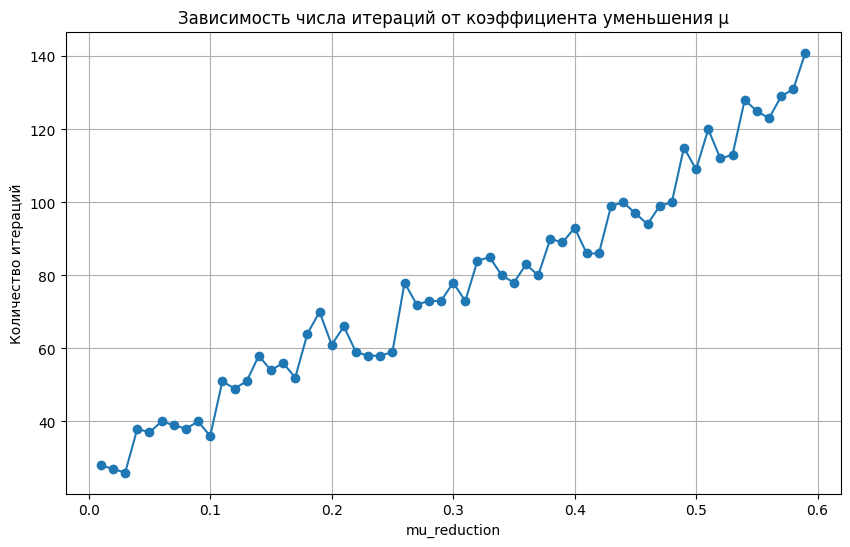

In [ ]:
def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

results = []
mu_start = 1.0
mu_end = 1e-3
constraints = [constraint1]
mu_ar = np.arange(0.01, 0.6, 0.01)
tol = 0.0001

for mu_reduction in mu_ar:
  x0 = [1.0, 1.0, 1.0, 1.0, 1.0]
  x_sol = x0
  mu = mu_start
  total_iterations = 0

  while mu > mu_end:
    x_sol, num_iter = dfp_method(lambda x: combined_func(x, mu, constraints), x_sol, mu, tol=tol)
    mu *= mu_reduction
    total_iterations += num_iter

  results.append((mu_reduction, total_iterations))

# Построение графика
mu_reduction_values = [res[0] for res in results]
iterations_values = [res[1] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(mu_reduction_values, iterations_values, marker='o')
plt.xlabel('mu_reduction')
plt.ylabel('Количество итераций')
plt.title('Зависимость числа итераций от коэффициента уменьшения μ')
plt.grid(True)
plt.show()


In [ ]:
# Логарифмическая барьерная функция
def barrier(x, constraints):
    penalty = 0
    for constraint in constraints:
        value = constraint(x)
        if value <= 0:
            return float('inf')
        penalty -= np.log(value)
    return penalty

# Квадратичный штраф
def quadratic_penalty(x, constraints):
    penalty = 0
    for constraint in constraints:
        penalty += max(0, -constraint(x)) ** 2
    return penalty

# Обратная квадратичная барьерная функция
def inverse_square_barrier(x, constraints):
    penalty = 0
    for constraint in constraints:
        value = constraint(x)
        if value <= 0:
            return float('inf')
        penalty += 1 / (value**2)
    return penalty

# Экспоненциальная барьерная функция
def exponential_barrier(x, constraints, alpha=1.0):
    penalty = 0
    for constraint in constraints:
        value = constraint(x)
        penalty += np.exp(-alpha * value)
    return penalty

def combined_func_exponential(x, mu, constraints, alpha=1.0):
    return objective(x) + mu * exponential_barrier(x, constraints, alpha)

def combined_func_barrier(x, mu, constraints):
    return objective(x) + mu * barrier(x, constraints)

def combined_func_penalty(x, mu, constraints):
    return objective(x) + mu * quadratic_penalty(x, constraints)

def combined_func_inverse_square(x, mu, constraints):
    return objective(x) + mu * inverse_square_barrier(x, constraints)

def objective(x):
    return sum([(x[i] - 7)**2 + 42 * (x[i+1] - x[i]**2)**2 for i in range(len(x) - 1)])

def constraint1(x):
    return 72 - sum([i * x[i - 1]**2 for i in range(1, len(x) + 1)])

constraints = [constraint1]
x_0_arr = [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0], [2.0, 0.0, 1.0, 0.0, -1.0], [0.0, -1.0, 0.0, 1.0, 0.0]]

for x0 in x_0_arr:
  print("Для x0:", x0)

  # Запуск с логарифмической барьерной функцией
  total_iterations = 0
  mu_start = 1.0
  mu_end = 1e-3
  x_sol_barrier = x0
  mu = mu_start

  while mu > mu_end:
    x_sol_barrier, iters_barrier = dfp_method(lambda x: combined_func_barrier(x, mu, constraints), x_sol_barrier, mu)
    mu *= mu_reduction
    total_iterations += iters_barrier

  print(objective(x_sol_barrier))
  print("Логарифмическая барьерная функция: кол-во итераций =", total_iterations)

  # Запуск с экспоненциальной барьерной функцией
  total_iterations = 0
  mu_start = 1.0
  mu_end = 1e-3
  x_sol_exp = x0
  mu = mu_start

  while mu > mu_end:
    x_sol_exp, iters_exp = dfp_method(lambda x: combined_func_exponential(x, mu, constraints), x_sol_exp, mu)
    mu *= mu_reduction
    total_iterations += iters_exp

  print(objective(x_sol_exp))
  print("Экспоненциальная барьерная функция: кол-во итераций =", total_iterations)

  # Запуск с квадратичной штрафной функцией
  total_iterations = 0
  mu_start = 1.0
  mu_end = 1e-3
  x_sol_penalty = x0
  mu = mu_start

  while mu > mu_end:
    x_sol_penalty, iters_penalty = dfp_method(lambda x: combined_func_penalty(x, mu, constraints), x_sol_penalty, mu)
    mu *= mu_reduction
    total_iterations += iters_barrier

  print(objective(x_sol_penalty))
  print("Квадратичная штрафная функция: кол-во итераций =", total_iterations)

  # Запуск с обратной квадратичной барьерной функцией
  total_iterations = 0
  mu_start = 1.0
  mu_end = 1e-3
  x_sol_inverse_square = x0
  mu = mu_start

  while mu > mu_end:
    x_sol_inverse_square, iters_inverse_square = dfp_method(lambda x: combined_func_inverse_square(x, mu, constraints), x_sol_inverse_square, mu)
    mu *= mu_reduction
    total_iterations += iters_barrier

  print(objective(x_sol_inverse_square))
  print("Обратная квадратичная барьерная функция: кол-во итераций =", total_iterations)
  print('\n\n')

Для x0: [0.0, 0.0, 0.0, 0.0, 0.0]


<ipython-input-62-54cb676345f5>:65: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f(x_h) - f(x)) / epsilon


127.83772262783746
Логарифмическая барьерная функция: кол-во итераций = 217
127.83772262783746
Экспоненциальная барьерная функция: кол-во итераций = 217
127.83772262783746
Квадратичная штрафная функция: кол-во итераций = 140
127.83772262783746
Обратная квадратичная барьерная функция: кол-во итераций = 140



Для x0: [1.0, 1.0, 1.0, 1.0, 1.0]
127.83772262821518
Логарифмическая барьерная функция: кол-во итераций = 215
127.83772262821518
Экспоненциальная барьерная функция: кол-во итераций = 215
127.83772262821518
Квадратичная штрафная функция: кол-во итераций = 140
127.83772262821518
Обратная квадратичная барьерная функция: кол-во итераций = 140



Для x0: [2.0, 0.0, 1.0, 0.0, -1.0]
158.1542997547393
Логарифмическая барьерная функция: кол-во итераций = 264
158.1542997547393
Экспоненциальная барьерная функция: кол-во итераций = 264
158.1542997547393
Квадратичная штрафная функция: кол-во итераций = 168
158.1542997547393
Обратная квадратичная барьерная функция: кол-во итераций = 168



Для x